In [1]:


import numpy as np # linear algebra
import tensorflow as tf # for tensorflow based registration
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.util.montage import montage2d
import os
from cv2 import imread, createCLAHE # read and equalize images
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt



/home/duilio/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cxr_paths = glob(os.path.join('MontgomerySet', '*', '*.jpg'))
cxr_images = [(c_path, 
               [os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','leftMask', os.path.basename(c_path))]
              ) for c_path in cxr_paths]
print('CXR Images', len(cxr_paths), cxr_paths[0])
print(cxr_images[0])

CXR Images 131 MontgomerySet/CXR_png/Imagen121.jpg
('MontgomerySet/CXR_png/Imagen121.jpg', ['MontgomerySet/ManualMask/leftMask/Imagen121.jpg'])


In [3]:
# imagen=plt.imread('MontgomerySet/ManualMask/leftMask/Imagen121.jpg')
# plt.imshow(imagen[:,:,1])

In [4]:
from skimage.io import imread as imread_raw
from skimage.transform import resize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore', category=UserWarning, module='skimage') # skimage is really annoying
OUT_DIM = (512, 512)
def imread(in_path, apply_clahe = False, exp_dim=True):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    if exp_dim:
        return np.expand_dims(n_img, -1)
    else:
        return n_img

In [8]:
img_vol, seg_vol = [], []
for img_path, s_paths in tqdm(cxr_images):
#     print(img_path)
#     print(s_paths)

    img_vol += [imread(img_path)]    
    seg_vol += [cv2.cvtColor(imread(s_paths[0], apply_clahe = False, exp_dim=False), cv2.COLOR_RGB2GRAY)]
#    seg_vol += [imread(s_paths[0], apply_clahe = False, exp_dim=False)]

#     seg_vol += [np.max(np.stack([print(s_path)for s_path in s_paths],0),0)]
#     input()
img_vol = np.stack(img_vol,0)
seg_vol = np.stack(seg_vol,0)
seg_vol = np.expand_dims(seg_vol, -1)
print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

100%|██████████| 131/131 [00:11<00:00, 11.39it/s]

Images (131, 512, 512, 1) Segmentations (131, 512, 512, 1)


In [14]:
np.unique(seg_vol[0,:,:,0])

array([ 13,  14,  18,  19,  20,  21,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 138, 141,
       146, 190, 192, 198, 201, 205, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255], dtype=uint8)

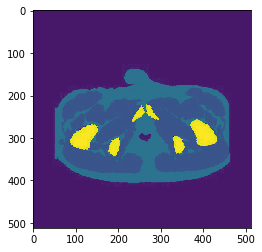

In [16]:
plt.imshow(seg_vol[0,:,:,0])

/home/duilio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  """Entry point for launching an IPython kernel.


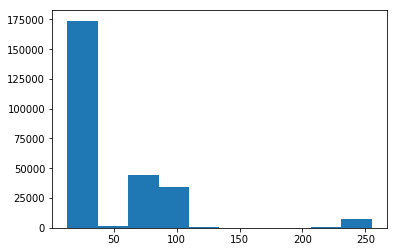

In [24]:
a=plt.hist(seg_vol[0].ravel(255))
# plot(a)

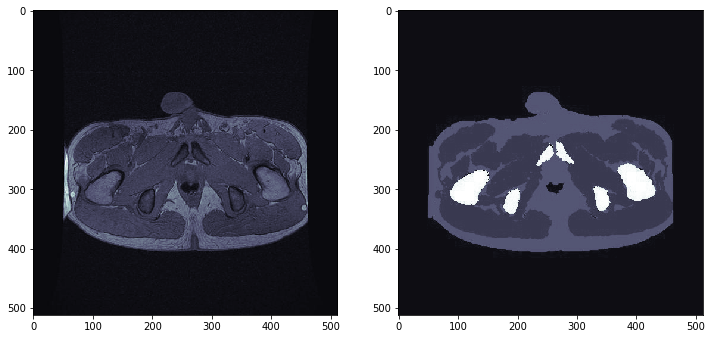

In [9]:
np.random.seed(2018)
t_img, m_img = img_vol[0], seg_vol[0]

fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(t_img[:,:,0],
               cmap = 'bone')
ax_mask.imshow(m_img[:,:,0], cmap = 'bone')

In [76]:
from keras.layers import Conv2D, Activation, Input, UpSampling2D, concatenate, BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
def c2(x_in, nf, strides=1):
    x_out = Conv2D(nf, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out
def unet_enc(vol_size, enc_nf, pre_filter = 8):
    src = Input(shape=vol_size + (1,), name = 'EncoderInput')
    # down-sample path.
    x_in = BatchNormalization(name = 'NormalizeInput')(src)
    x_in = c2(x_in, pre_filter, 1)
    x0 = c2(x_in, enc_nf[0], 2)  
    x1 = c2(x0, enc_nf[1], 2)  
    x2 = c2(x1, enc_nf[2], 2)  
    x3 = c2(x2, enc_nf[3], 2) 
    return Model(inputs = [src], 
                outputs = [x_in, x0, x1, x2, x3],
                name = 'UnetEncoder')

In [79]:
from keras.models import Model
from keras import layers
def unet(vol_size, enc_nf, dec_nf, full_size=True, edge_crop=48):
    """
    unet network for voxelmorph 
    Args:
        vol_size: volume size. e.g. (256, 256, 256)
        enc_nf: encoder filters. right now it needs to be to 1x4.
            e.g. [16,32,32,32]
            TODO: make this flexible.
        dec_nf: encoder filters. right now it's forced to be 1x7.
            e.g. [32,32,32,32,8,8,3]
            TODO: make this flexible.
        full_size
    """

    # inputs
    raw_src = Input(shape=vol_size + (1,), name = 'ImageInput')
    src = layers.GaussianNoise(0.25)(raw_src)
    enc_model = unet_enc(vol_size, enc_nf)
    # run the same encoder on the source and the target and concatenate the output at each level
    x_in, x0, x1, x2, x3 = [s_enc for s_enc in enc_model(src)]

    x = c2(x3, dec_nf[0])
    x = UpSampling2D()(x)
    x = concatenate([x, x2])
    x = c2(x, dec_nf[1])
    x = UpSampling2D()(x)
    x = concatenate([x, x1])
    x = c2(x, dec_nf[2])
    x = UpSampling2D()(x)
    x = concatenate([x, x0])
    x = c2(x, dec_nf[3])
    x = c2(x, dec_nf[4])
    x = UpSampling2D()(x)
    x = concatenate([x, x_in])
    x = c2(x, dec_nf[5])

    # transform the results into a flow.
    y_seg = Conv2D(1, kernel_size=3, padding='same', name='lungs', activation='softmax')(x)
    y_seg = layers.Cropping2D((edge_crop, edge_crop))(y_seg)
    y_seg = layers.ZeroPadding2D((edge_crop, edge_crop))(y_seg)
    # prepare model
    model = Model(inputs=[raw_src], outputs=[y_seg])
    return model

In [80]:
# use the predefined depths
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,2]
net = unet(OUT_DIM, nf_enc, nf_dec)
# ensure the model roughly works
a= net.predict([np.zeros((1,)+OUT_DIM+(1,))])
print(a.shape)
net.summary()

(1, 512, 512, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
gaussian_noise_4 (GaussianNoise (None, 512, 512, 1)  0           ImageInput[0][0]                 
__________________________________________________________________________________________________
UnetEncoder (Model)             [(None, 512, 512, 8) 24388       gaussian_noise_4[0][0]           
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 32, 32)   9248        UnetEncoder[1][4]                
____________________________________________________________________________________________

In [83]:
from keras.optimizers import Adam
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

reg_param = 1.0
lr = 2e-4
dice_bce_param = 0.0
use_dice = True

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return dice_bce_param*categorical_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

net.compile(optimizer=Adam(lr=lr), 
              loss=[dice_p_bce], 
           metrics = [true_positive_rate, 'accuracy'])

Train (104, 512, 512, 1) Test (27, 512, 512, 1) -0.7373800080244591 1.0
Seg (104, 512, 512, 1) 255.0 [ 10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.
  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.
  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.
  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135.
 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.
 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163.
 165. 166. 167. 174. 180. 181. 182. 184. 186. 187. 188. 189. 190. 191.
 192. 193. 194. 195. 196. 197. 198. 199. 200. 2

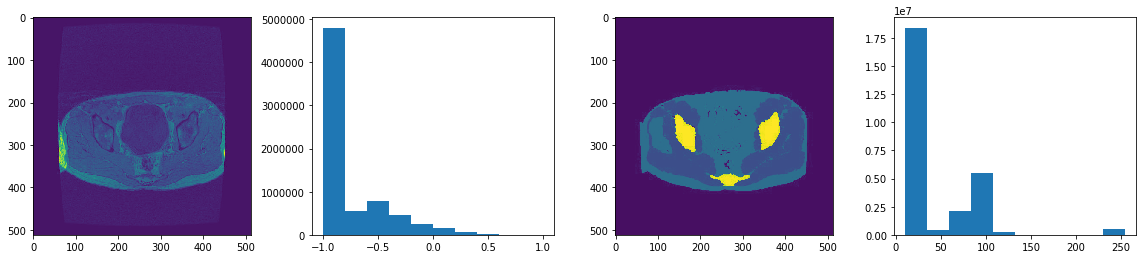

In [87]:
from sklearn.model_selection import train_test_split
train_vol, test_vol, train_seg, test_seg = train_test_split((img_vol-127.0)/127.0, 
                                                            (seg_vol).astype(np.float32), 
                                                            test_size = 0.2, 
                                                            random_state = 2018)
print('Train', train_vol.shape, 'Test', test_vol.shape, test_vol.mean(), test_vol.max())
print('Seg', train_seg.shape, train_seg.max(), np.unique(train_seg.ravel()))
fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1, 4, figsize = (20, 4))
ax1.imshow(test_vol[0, :, :, 0])
ax1hist.hist(test_vol.ravel())
ax2.imshow(test_seg[0, :, :, 0])
ax2hist.hist(trhain_seg.ravel());

In [71]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,
                  zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
                  horizontal_flip = True,  
                  vertical_flip = False,
                  fill_mode = 'nearest',
               data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

def gen_augmented_pairs(in_vol, in_seg, batch_size = 16):
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_vol = image_gen.flow(in_vol, batch_size = batch_size, seed = seed)
        g_seg = image_gen.flow(in_seg, batch_size = batch_size, seed = seed)
        for i_vol, i_seg in zip(g_vol, g_seg):
            yield i_vol, i_seg

In [72]:
train_gen = gen_augmented_pairs(train_vol, train_seg, batch_size = 16)
test_gen = gen_augmented_pairs(test_vol, test_seg, batch_size = 16)
train_X, train_Y = next(train_gen)
test_X, test_Y = next(test_gen)
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)


(16, 512, 512, 1) (16, 512, 512, 1)
(16, 512, 512, 1) (16, 512, 512, 1)


Text(0.5,1,'Seg Image')

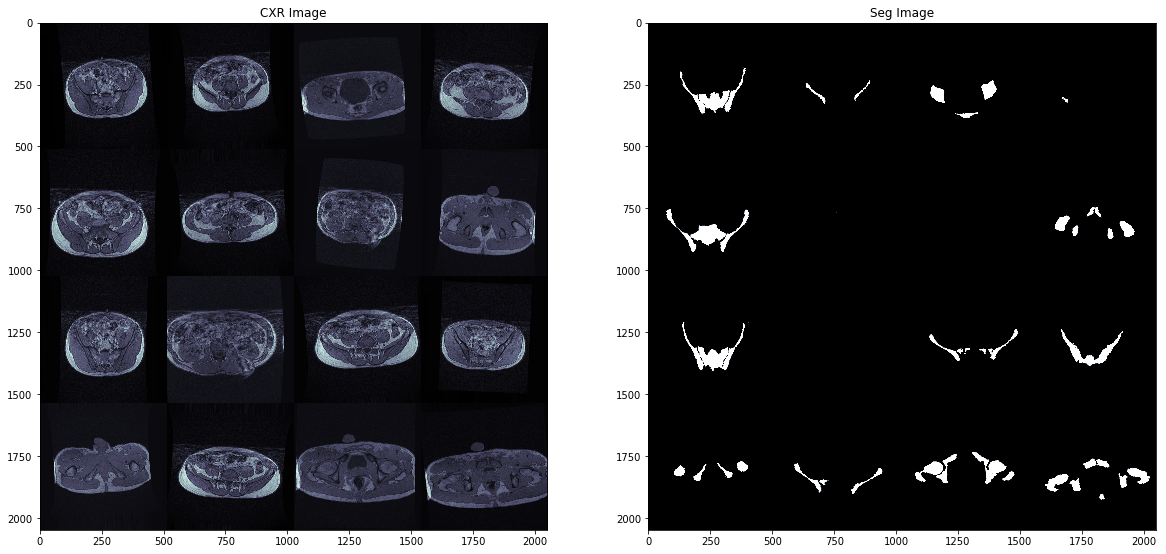

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(train_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(train_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')

Text(0.5,1,'Seg Image')

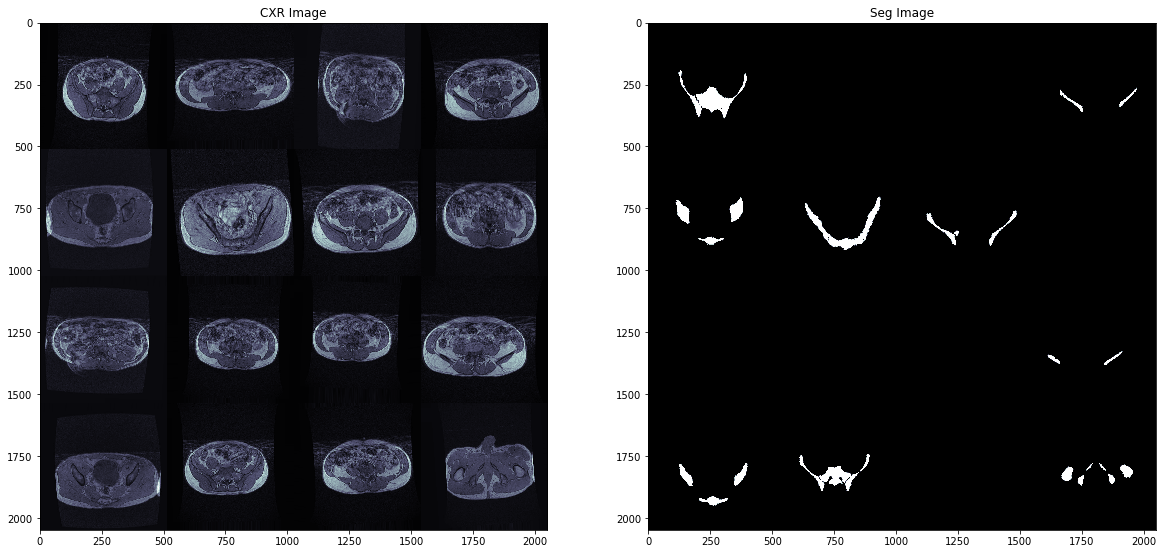

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(test_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(test_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')